## 0 - Libraries

In [3]:
import speasy as spz
from speasy import amda 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
#choose kernel (keras-env) when run on Macbook Pro 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
from datetime import datetime
import calendar
import os
import random

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
def E_mhd(df):
    '''
    [B] = nT
    [u] = km/s
    [E] = µV/m => mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']=(df['by']*df['uz']-df['uy']*df['bz'])/1e3
    dg['ey']=-(df['bz']*df['ux']-df['uz']*df['bx'])/1e3 #MINUS SIGN TO FIT MEASUREMENTS IN MMS1 MAYBE THERE IS A ISSUE WITH THE MEASUREMENT TOOL IN MMS1
    dg['ez']=(df['bx']*df['uy']-df['ux']*df['by'])/1e3
    return dg

def E_hall(df):
    '''
    [B] = nT
    [j] = A/m^2
    [n] = cm^-3
    [E] = *1e-15 V/m => 1e-12 mV/m
    '''
    dg = pd.DataFrame(index=df.index,columns=['ex','ey','ez'])
    dg['ex']= ((df['jy']*df['bz']-df['by']*df['jz'])/(e*df['e_density']))/1e12
    dg['ey']= ((df['jz']*df['bx']-df['bz']*df['jx'])/(e*df['e_density']))/1e12
    dg['ez']= ((df['jx']*df['by']-df['bx']*df['jy'])/(e*df['e_density']))/1e12
    return dg

In [5]:
### Fix the random seed for producible resutls 

# Seed value
seed = 1
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set the `python` built-in pseudo-random generator at a fixed value

random.seed(seed)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)
# 5. Configure a new global `tensorflow` session
from keras import backend as K

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


2024-04-02 11:14:56.307571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-02 11:14:57.401984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7628 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:9e:00.0, compute capability: 7.5


In [6]:
e = 1.602176634e-19
m_i = 1.67262192369e-27
m_e = 9.1093837015e-31

In [7]:
## Global interval - all the data will be inside this range
sat = 'mms1'
t1 = datetime(2015,9,7,0,0,0)
t2 = datetime(2015,9,30,0,0,0)

In [8]:
store = pd.HDFStore('./data.hdf5','r')
bursts = store.keys()
store.close()

In [9]:
bursts = [datetime.strptime(burst, '/mms1_%Y_%m_%dT%H_%M_%S') for burst in bursts]
bursts = pd.DataFrame(bursts)

In [10]:
bursts = bursts.where((str(t1.date()) < bursts)&(bursts < str(t2.date()))).dropna()
df = pd.concat([pd.read_hdf('./data.hdf5',key=sat+"_"+datetime.strftime(pd.to_datetime(event[0]),format='%Y_%m_%dT%H_%M_%S')) for event in bursts.values]).dropna()

In [11]:
df['ux']=(m_i*df['vx_i']+m_e*df['vx_e'])/(m_i+m_e)
df['uy']=(m_i*df['vy_i']+m_e*df['vy_e'])/(m_i+m_e)
df['uz']=(m_i*df['vz_i']+m_e*df['vz_e'])/(m_i+m_e)
df = df.where(df['e_density']>1).dropna()

In [12]:
PINNS = True

if PINNS:
    df[['ex_mhd','ey_mhd','ez_mhd']] = E_mhd(df)
    df[['ex_hall','ey_hall','ez_hall']] = E_hall(df)
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'ex_mhd','ey_mhd','ez_mhd',
                'ex_hall','ey_hall','ez_hall',
                'e_density',]
    output_targets = ['ex','ey','ez']
else:
    ## Input / Output wanted
    input_features = ['bx', 'by', 'bz',
                'jx', 'jy', 'jz',
                'ux', 'uy', 'uz',
                'e_density',]
    output_targets = ['ex','ey','ez']

df = df.drop(df.columns.drop(input_features+output_targets),axis=1)

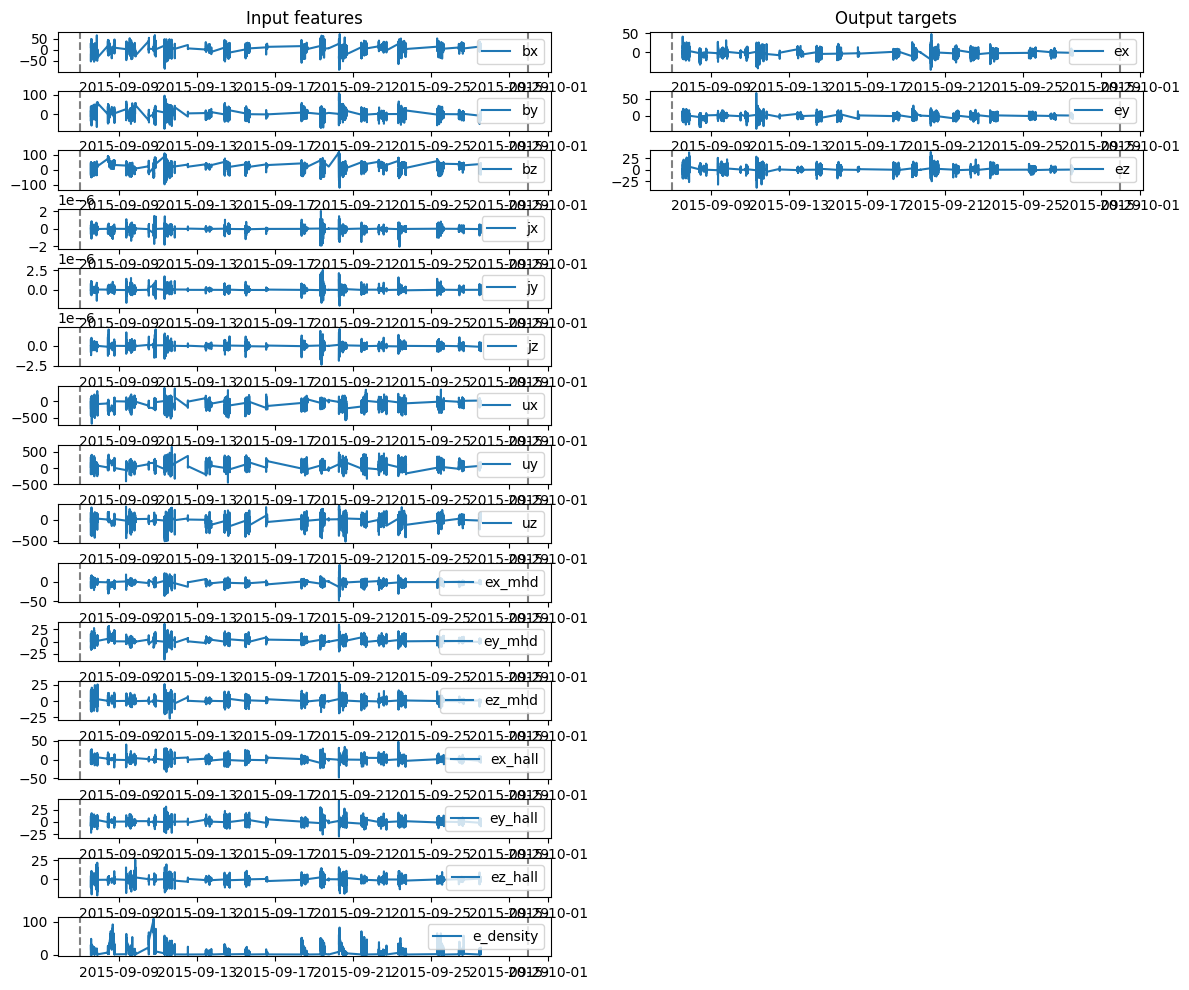

In [13]:
fig, ax = plt.subplots(len(input_features), 2, figsize=(14,12))
plt.subplots_adjust(hspace=0.5)
for i, col in enumerate(input_features):
    ax[i,0].plot(df[col], label=col)
    ax[i,0].legend(loc='upper right',bbox_to_anchor=(1.0, 1.0))
    ax[i,0].axvline(x=t1, ls='--', color='grey')
    ax[i,0].axvline(x=t2, ls='--', color='grey')
    #ax[i,0].set_xlim(t1, t2)
    #ax[i,0].xaxis.set_major_locator(mdates.MonthLocator(interval=24))
    #ax[i,0].xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
    #ax[i,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    if i>=len(output_targets):
        ax[i,1].axis('off')

for j,col in enumerate(output_targets):
    ax[j,1].plot(df[col], label=col)
    ax[j,1].legend(loc='upper right',bbox_to_anchor=(1.0, 1.0))
    ax[j,1].axvline(x=t1, ls='--', color='grey')
    ax[j,1].axvline(x=t2, ls='--', color='grey')
    #ax[j,1].set_xlim(t1, t2)
    #ax[j,1].xaxis.set_major_locator(mdates.MonthLocator(interval=24))
    #ax[j,1].xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
    #ax[j,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    if j>=len(input_features):
        ax[j,0].axis('off')

ax[0,0].set_title('Input features')

ax[0,1].set_title('Output targets')

plt.show()

In [14]:
## Global interval - all the data will be inside this range
f_train, f_test, f_valid = 0.80, 0.1, 0.1
## Train interval 
id_train_beg = 0
id_train_end = int(len(df.index)*(f_train))

t_train_begin = df.index.values[0]
t_train_end = df.index.values[id_train_end]
print("Train interval: ", t_train_begin, t_train_end)

## Validation interval

id_val_beg = id_train_end+1
id_val_end = int(len(df.index)*(f_train+f_valid))
t_val_begin = df.index.values[id_val_beg]
t_val_end = df.index.values[id_val_end]
print("Validation interval: ", t_val_begin, t_val_end)

## Test interval 
id_test_beg = id_val_end + 1
id_test_end =  int(len(df.index))-1
t_test_begin = df.index.values[id_test_beg]
t_test_end = df.index.values[id_test_end]
print("Test interval: ", t_test_begin, t_test_end)


df_train, df_test = train_test_split(df,test_size = f_test+f_valid,train_size=f_train,random_state=seed,shuffle=False)
df_val, df_test = df_test.iloc[:len(df_test)//2,:], df_test.iloc[len(df_test)//2:,:]

Train interval:  2015-09-07T13:12:32.321000000 2015-09-23T08:55:43.999000000
Validation interval:  2015-09-23T08:55:44.149000000 2015-09-25T11:56:46.080000000
Test interval:  2015-09-25T11:56:46.230000000 2015-09-27T13:22:43.727000000


In [15]:
def f(X,mid):
    Y = mid + (X - X.mean()) / (X.max() - X.min())
    return Y

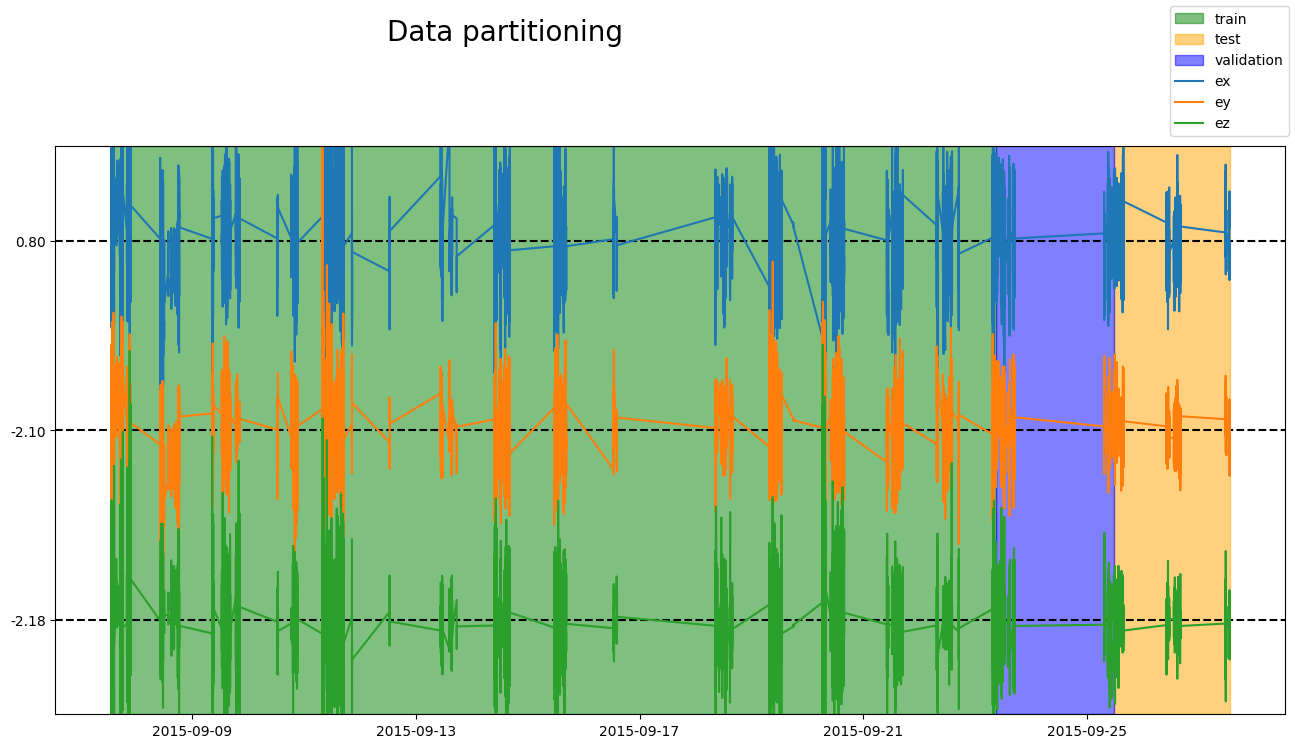

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.25)

ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label='train',color='green',alpha=0.5)
ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label='validation',color='blue',alpha=0.5)
ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label='test',color='orange',alpha=0.5)



mids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2

ax.axhline(mids[0],color='black',linestyle='--')
ax.axhline(mids[1],color='black',linestyle='--')
ax.axhline(mids[2],color='black',linestyle='--')
ax.plot(df.index.values,1*f(df['ex'],mids[-1]),label='ex')
ax.plot(df.index.values,1*f(df['ey'],mids[-2]),label='ey')
ax.plot(df.index.values,1*f(df['ez'],mids[-3]),label='ez')

ax.set_yticks(mids,[f'{df[e].mean():.2f}' for e in ['ex','ey','ez']])
ax.set_ylim(0,1)
fig.legend()

fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1.15)
fig.suptitle("Data partitioning", fontsize=20)

plt.show()

In [17]:
df = df.where(df['e_density']>1).dropna()
#extract trend ?
df0 = df

In [18]:
df = df.drop(df.columns.drop(input_features+output_targets),axis=1) #drop useless data
df = df[input_features + output_targets] #reorder columns for input to the left and output to the right

In [19]:
# Divide the data before scaling
df_train = df[id_train_beg:id_train_end]
df_val = df[id_val_beg:id_val_end]
df_test = df[id_test_beg:id_test_end]
## Define a scaler function
scaler = MinMaxScaler()
## Obtain scaler based on the “train” data
df_train_scaled = scaler.fit_transform(df_train)
## Apply the scaling obtained from the “train” data to “validation” and “test” data
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)

In [20]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]
X_test = df_test_scaled[:,0:len(input_features)]
X_val = df_val_scaled[:,0:len(input_features)]
## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_test = df_test_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_val = df_val_scaled[:,len(input_features):len(input_features)+len(output_targets)]

In [29]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model(f'../Saved_models/DNN_PINNS={PINNS}/model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 64)                1088      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 5,715
Trainable params: 5,715
Non-trainable params: 0
_________________________________________________________________


In [30]:
test_predict = new_model.predict(X_test)

 364/1688 [=====>........................] - ETA: 2s

1688/1688 [==============================] - 3s 2ms/step


In [23]:
print('Test 1', t_test_begin, t_test_end)

score_test = new_model.evaluate(X_test, y_test, verbose=0)
print('\nLoss score = ', score_test)

mse_test = []
for i in range(y_test.shape[1]):
    mse_test.append(mean_squared_error(y_test[:,i], test_predict[:,i]))
print('\nMSE of all targets = ', mse_test)

Pcc_xyz_test = []
for i in range(y_test.shape[1]):
    Pcc_xyz_test.append(round(np.corrcoef(y_test[:,i], test_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test)

r2_xyz_test = []
for i in range(y_test.shape[1]):
    r2_xyz_test.append(round(r2_score(y_test[:,i], test_predict[:,i]),3))
print('\nr2 of all targets = ', r2_xyz_test)


Test 1 2015-09-25T11:56:46.230000000 2015-09-27T13:22:43.727000000

Loss score =  0.005037596914917231

MSE of all targets =  [5.5919760102844345e-05, 3.860512779121945e-05, 5.7985263198353873e-05]

Pcc of all targets =  [0.976, 0.973, 0.889]

r2 of all targets =  [0.949, 0.947, 0.784]


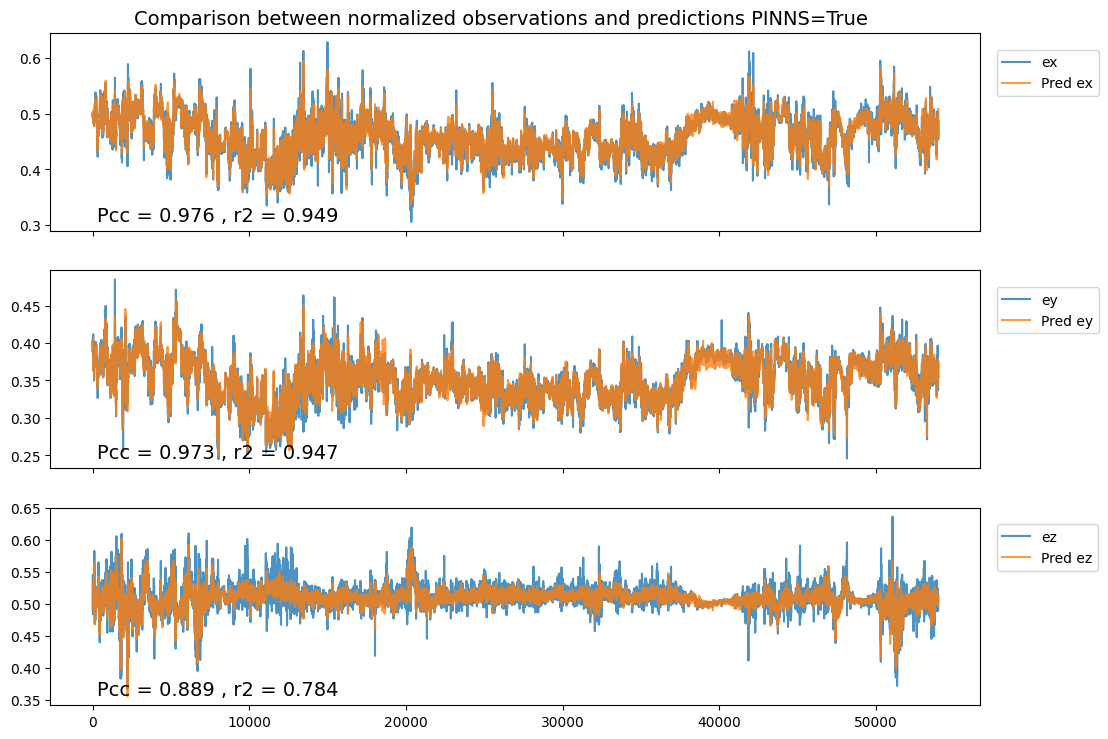

In [24]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test.shape[1]):
    ax[i].plot(y_test[:,i], label=target_labels[i],alpha=0.8)
    ax[i].plot(test_predict[:,i], label='Pred {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
    #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Comparison between normalized observations and predictions PINNS={PINNS}", fontsize=14)

plt.show()

In [25]:
# test
predict_scaled = np.concatenate((X_test[:,:],test_predict), axis=1)
print(predict_scaled.shape)
print(predict_scaled)

(53990, 19)
[[0.6288152  0.43665326 0.46430892 ... 0.49968231 0.40071696 0.53431761]
 [0.6217995  0.43445038 0.46163242 ... 0.50180823 0.39930594 0.53136504]
 [0.6146287  0.43815911 0.45928885 ... 0.50327981 0.40301967 0.53385615]
 ...
 [0.6021093  0.41530829 0.67244807 ... 0.46492311 0.36818093 0.50843978]
 [0.60294888 0.41510062 0.67263937 ... 0.47613326 0.36610812 0.50531805]
 [0.60407581 0.41506601 0.67249361 ... 0.47505388 0.3709057  0.50557256]]


In [26]:
# test 
predict = scaler.inverse_transform(predict_scaled)
print(predict)
print(predict.shape)

[[ 1.07344229e+01  6.41753267e+00 -1.04728466e+01 ...  1.38743046e+00
   3.14287582e+00  2.25270926e+00]
 [ 9.60744311e+00  6.01439007e+00 -1.11124456e+01 ...  1.58349761e+00
   2.99274849e+00  2.02312851e+00]
 [ 8.45554668e+00  6.69311300e+00 -1.16724816e+01 ...  1.71921696e+00
   3.38787516e+00  2.21682799e+00]
 ...
 [ 6.44446704e+00  2.51125994e+00  3.92656732e+01 ... -1.81830625e+00
  -3.18836128e-01  2.40550072e-01]
 [ 6.57933436e+00  2.47325548e+00  3.93113895e+01 ... -7.84428162e-01
  -5.39375484e-01 -2.18373723e-03]
 [ 6.76036127e+00  2.46692092e+00  3.92765559e+01 ... -8.83976205e-01
  -2.89311337e-02  1.76061082e-02]]
(53990, 19)


In [27]:
# test 
df_predict = pd.DataFrame(predict)
df_predict.columns = df0.columns
df_predict['time'] = df.index[id_test_beg:id_test_end]
df_predict = df_predict.set_index(['time'])
df_predict

,ex,ey,ez,bx,by,bz,jx,jy,jz,e_density,ux,uy,uz,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall
time,,,,,,,,,,,,,,,,,,,
2015-09-25 11:56:46.230,10.734423,6.417533,-10.472847,-2.431440e-09,1.053418e-08,3.714235e-10,-293.467796,110.141051,-15.792772,1.052140,-3.242970,3.065640,-0.045765,-0.008721,-0.052252,15.370977,1.387430,3.142876,2.252709
2015-09-25 11:56:46.380,9.607443,6.014390,-11.112446,-3.510310e-08,-3.805311e-09,-8.369597e-08,-292.542921,111.532840,-14.809120,1.150335,-3.393145,2.831013,0.219203,-0.479723,-0.070125,15.537141,1.583498,2.992748,2.023129
2015-09-25 11:56:46.530,8.455547,6.693113,-11.672482,-3.141334e-08,-6.549999e-08,-9.692812e-10,-294.460971,108.786392,-15.322962,1.167249,-3.566654,2.890709,0.287509,-0.139783,0.128119,16.738311,1.719217,3.387875,2.216828
2015-09-25 11:56:46.680,7.185143,5.692874,-9.990539,-7.435405e-08,-5.631260e-08,2.774463e-08,-296.735586,106.118827,-16.529180,0.966086,-3.083313,2.451757,0.144254,-0.193750,-0.006657,17.508017,1.396888,2.879587,1.837280
2015-09-25 11:56:46.830,6.992594,4.672051,-8.417921,-1.981816e-08,-3.158660e-08,-8.701236e-08,-295.678259,102.305374,-13.804624,0.796703,-2.585526,2.096804,0.230190,-0.265398,0.043914,18.232409,1.230247,2.397385,1.510697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-27 13:22:42.977,6.484812,2.669309,39.145933,-8.353964e-08,6.055221e-08,-6.485598e-08,-80.606232,95.773545,-39.235626,-3.853877,2.900970,0.836236,3.958804,4.435332,-0.958244,4.010109,-0.084687,0.380591,-0.214371
2015-09-27 13:22:43.127,6.423076,2.607949,39.239001,-7.669958e-08,4.791303e-08,-9.145053e-08,-82.517467,91.828668,-42.248519,-3.713447,2.966538,0.805024,3.496988,3.998228,-0.838161,3.781254,-0.380786,0.025290,-0.155122
2015-09-27 13:22:43.277,6.444467,2.511260,39.265673,-5.872861e-08,1.347942e-08,-4.870652e-08,-75.965825,92.638586,-40.924417,-3.740288,2.719113,0.787776,1.081507,3.306516,-0.388972,3.760425,-1.818306,-0.318836,0.240550


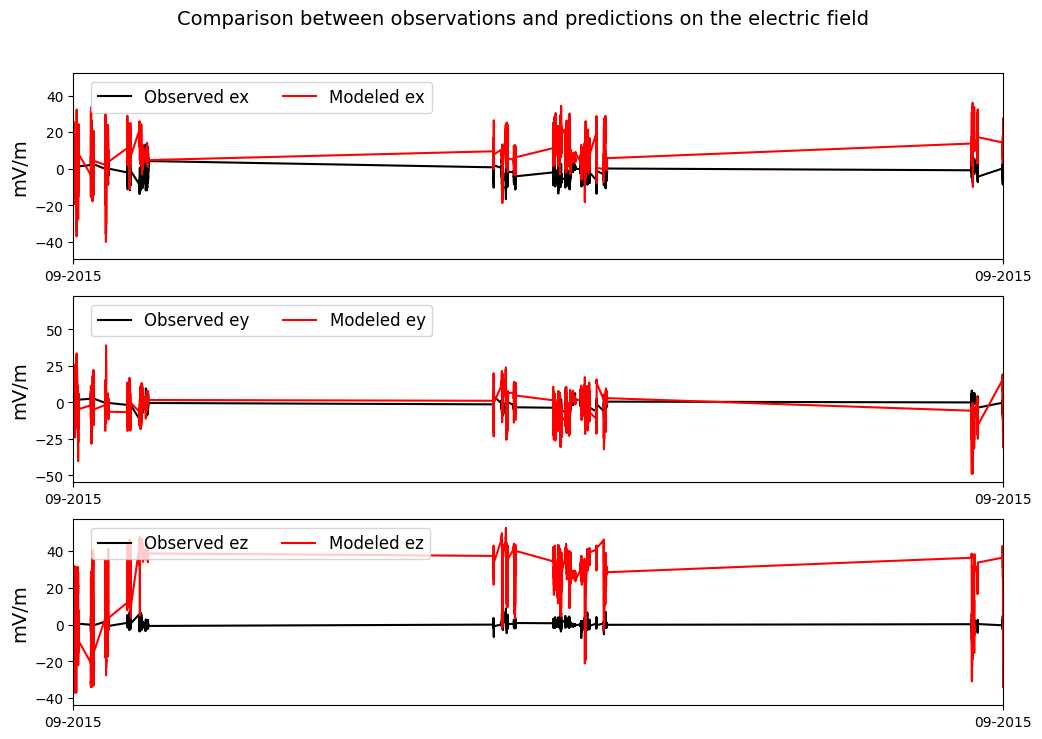

In [28]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(df0[col], label='Observed ' + col, color='k')
        ax[j].plot(df_predict[col], label='Modeled ' + col, color='r')
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_xlim(t_test_begin, t_test_end)
        ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()